# Import

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

import algorithms.bernstein_vazirani as bv
import algorithms.qft as qft

from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import IBMProvider

from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

# Parameters

In [2]:
def qiskit_opt_0(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=0)

def qiskit_opt_3(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3)

def qiskit_opt_3_sabre(qc: QuantumCircuit, backend):
    return transpile(qc, backend, optimization_level=3, layout_method='sabre', routing_method='sabre')

In [3]:
min_qubits, max_qubits = 4, 7
algorithms = { 'Bernstein Vazirani': bv, 'QFT': qft }
techniques = { 
    'Qiskit Opt 0': qiskit_opt_0, 
    'Qiskit Opt 3': qiskit_opt_3, 
    'Qiskit Opt 3 Sabre': qiskit_opt_3_sabre 
}

shots_per_technique = 100

In [4]:
provider = IBMProvider()
backend = provider.get_backend("ibm_oslo")

# Benchmark Transpilation with Tket

In [5]:
def pytket_run(qc, tk_backend):
    """Get compling results for a given circuit and Tket backend.
    
    Parameters:
        qc (QuantumCircuit): The circuit.
        tk_backend (TketBackend): A Tket backend instance.
        
    Returns:
        int: Number of CNOT gates in compiled circuit.
        float: Compilation time.
    """
    tk_qc = qiskit_to_tk(qc)
    st = time.perf_counter()
    tk_backend.default_compilation_pass(2).apply(tk_qc)
    ft = time.perf_counter()
    return tk_to_qiskit(tk_qc).count_ops()['cx'], ft-st

In [6]:
def qiskit_run(qc, backend, transpile_func):
    cx_counts = []
    min_time = float('inf')
    for i in range(shots_per_technique):
        st = time.perf_counter()
        tqc_temp = transpile_func(qc, backend)
        ft = time.perf_counter()
        compile_time = ft-st

        cx_counts.append(tqc_temp.count_ops()['cx'])
        if compile_time < min_time:
            min_time = compile_time
    return (cx_counts, min_time)

In [7]:
def qiskit_run_each_technique(qc, backend):
    cx_counts_per_transpile = []
    min_times = []

    for t_name, transpile_func in techniques.items():
        cx_counts, min_time = qiskit_run(qc, backend, transpile_func)
        cx_counts_per_transpile.append(cx_counts)
        min_times.append(min_time)
    return (cx_counts_per_transpile, min_times)

In [8]:
def compiler_benchmark(qc, backend, title=''):
    tk_backend = IBMQBackend(backend.name, group='uw-madison')
    tk_cx_count, tk_time = pytket_run(qc, tk_backend)
    fig, ax = plt.subplots(figsize=(9,5))
    plt.title(title)
    cx_counts_per_transpile, min_times = qiskit_run_each_technique(qc, backend)
    technique_names = list(techniques.keys())
    for i in range(len(techniques)):
        ax.hist(cx_counts_per_transpile[i], label='{} [{}]'.format(technique_names[i], np.round(min_times[i], 3)), alpha=0.7)
    ax.axvline(tk_cx_count, color='k', linewidth=4, linestyle='--',
               label='Tket [{}]'.format(np.round(tk_time, 3)))
    ax.set_xlabel('CX count', fontsize=14)
    ax.set_ylabel('Occurance', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")

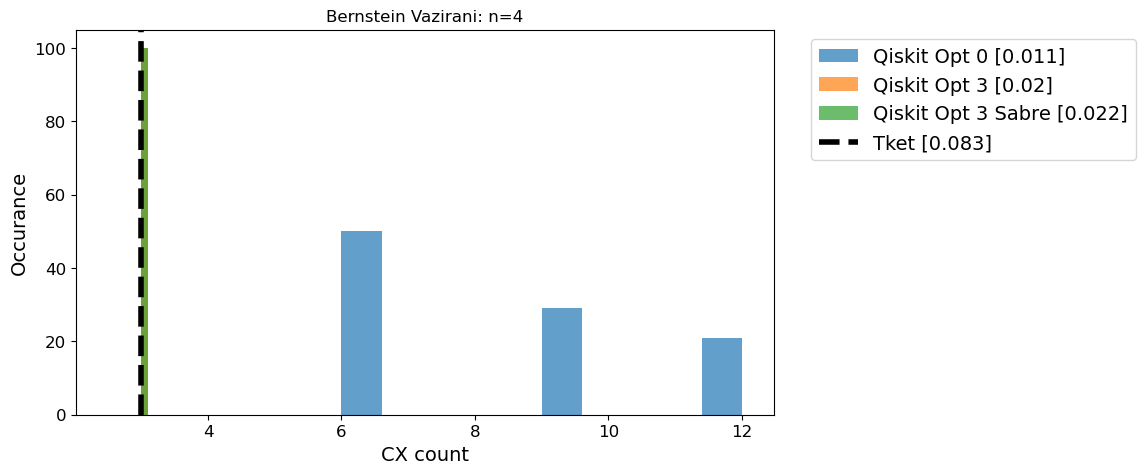

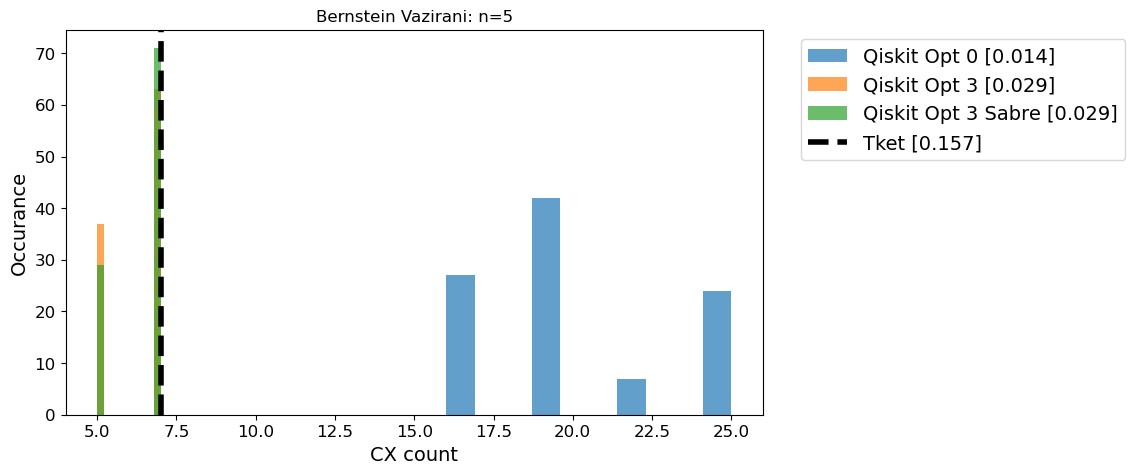

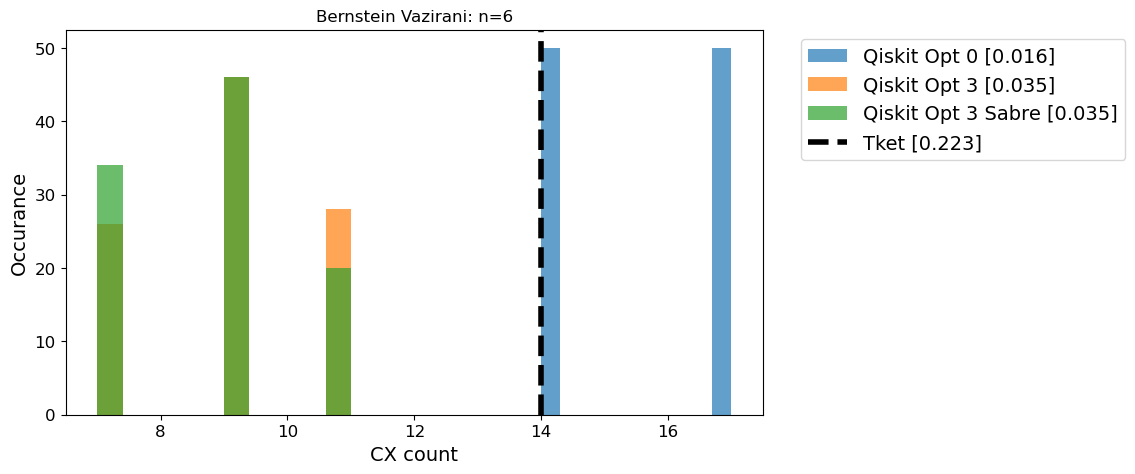

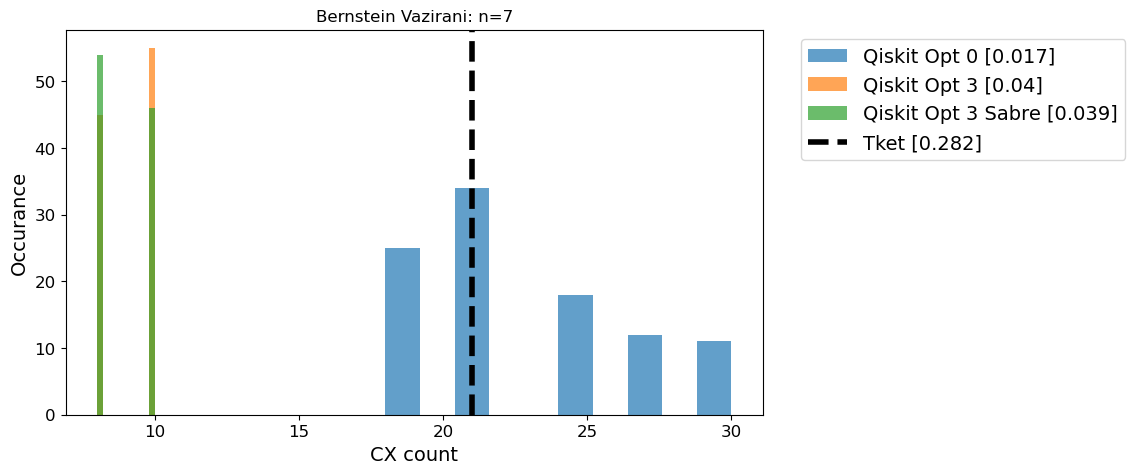

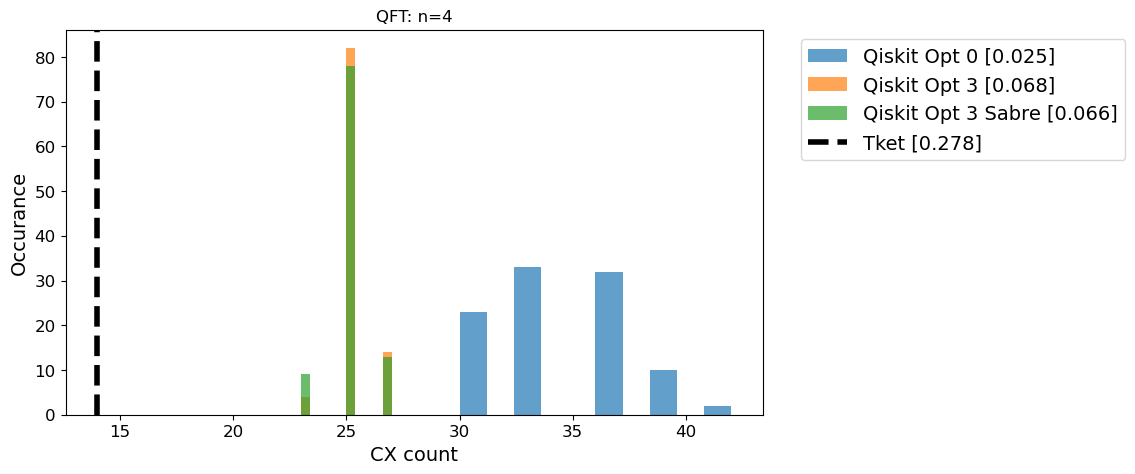

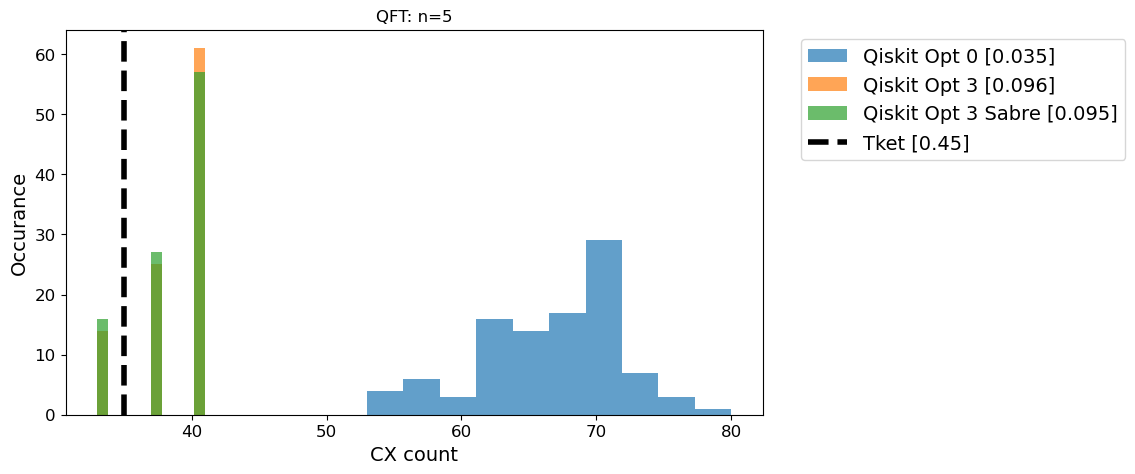

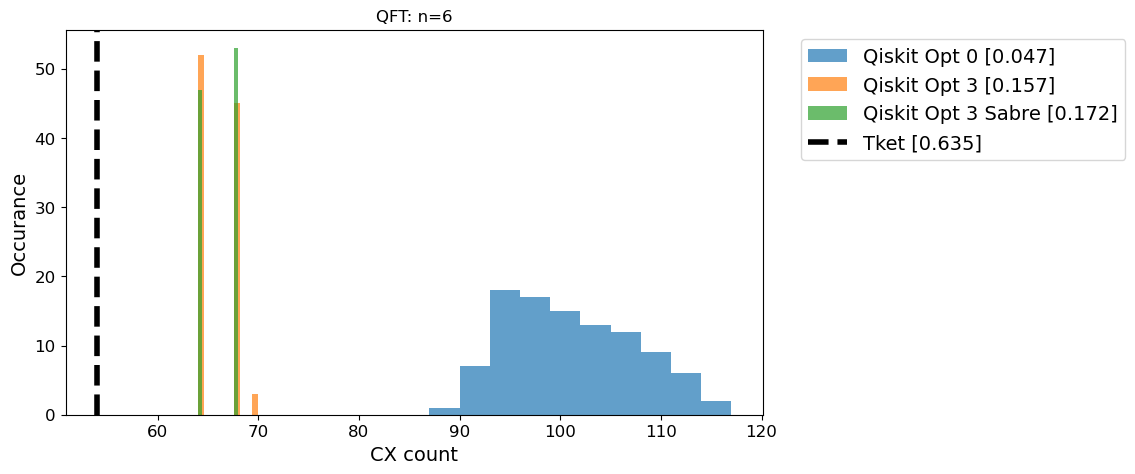

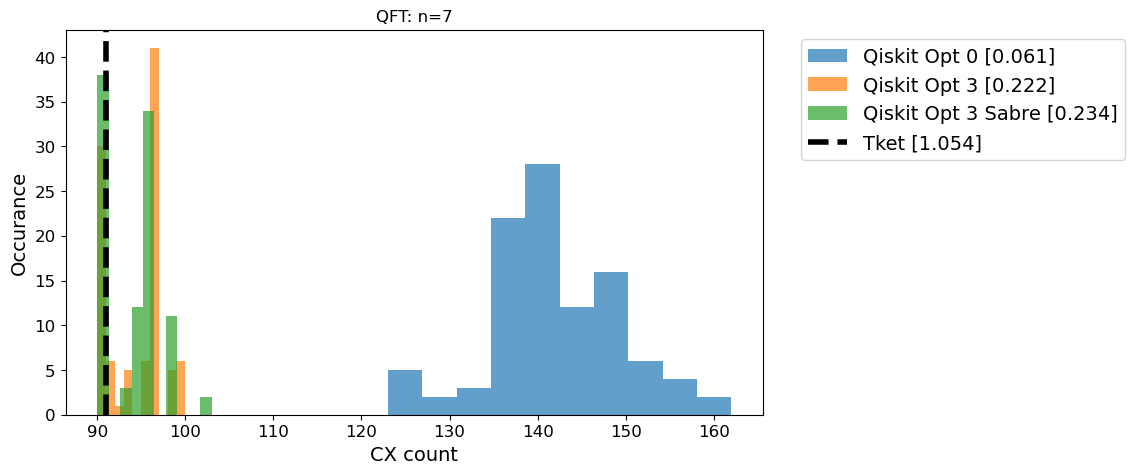

In [9]:
for algo_name, algo in algorithms.items():
    for n in range(min_qubits, max_qubits+1):
        compiler_benchmark(algo.test(n), backend, '{}: n={}'.format(algo_name, n))